In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [ ]:
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf

In [ ]:
!ls ../input/data-lfw/test

In [ ]:
cd ../input/data-lfw/test

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
face_images = glob.glob('*.jpg')

In [ ]:
all_images = []

for i in tqdm(face_images):
  img = image.load_img(i, target_size=(256,256,3))
  img = image.img_to_array(img)
  img = img/255.
  all_images.append(img)

In [ ]:
def pixalate_image(image, scale_percent = 73):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  low_res_image = cv2.resize(low_res_image, (256, 256)) 

  return low_res_image

In [ ]:

X =[]
Y =[]
for img in all_images:
  try:
      img = image.img_to_array(img)
     #lab = rgb2lab(img)
      px = pixalate_image(img)
      X.append(px) 
      Y.append(img) 
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
#X = X.reshape(X.shape+(-1,))
print(X.shape)
print(Y.shape)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))

    l3 = MaxPooling2D(padding='same')(l2)
    #l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l4)

    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l7)
    
    l8 = UpSampling2D()(l7)

    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

model = build_model()
model.summary()

In [ ]:
model.fit(X, Y,
          epochs = 25,
          batch_size = 32,
          verbose = 1,
          shuffle = True)

In [ ]:
face_images = glob.glob('*.jpg')

In [ ]:
all_images = []

for i in tqdm(face_images):
  img = image.load_img(i, target_size=(256,256,3))
  img = image.img_to_array(img)
  img = img/256.
  all_images.append(img)

100%|██████████| 3/3 [00:00<00:00, 283.03it/s]


In [ ]:
img = image.load_img("Abdel.jpg", target_size=(256,256,3))
img = image.img_to_array(img)
img = img/256.
img = np.array(img)
predictions = model.predict(img)

In [ ]:
all_images = np.array(all_images)
predictions = model.predict(all_images)

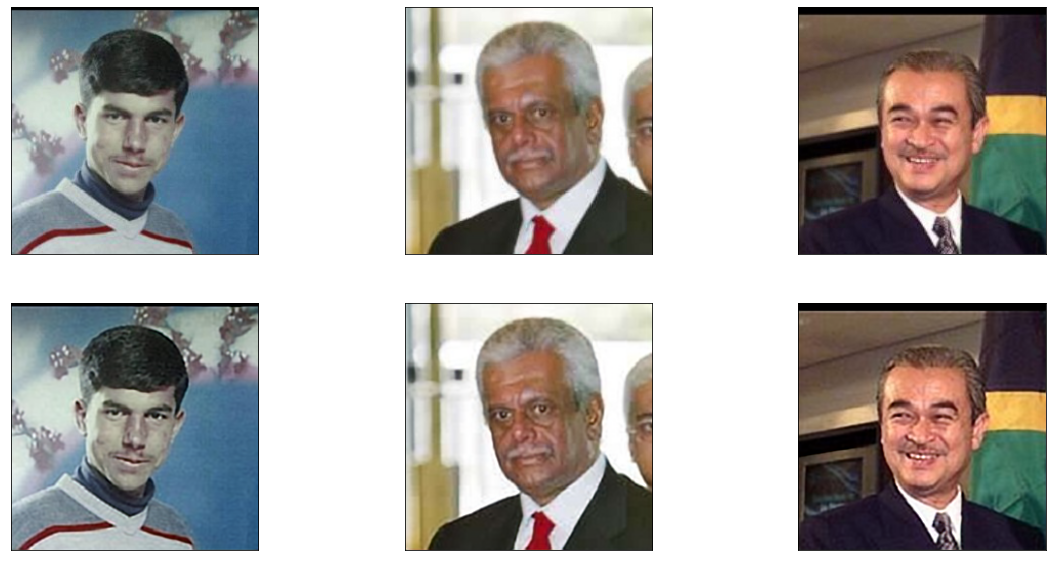

In [ ]:
n = 3
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(all_images[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i])
  #save_img(f'{i}.jpg', predictions[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [ ]:
model.save("./Inpainting.h5",save_format='h5')